In [26]:
try:
    import psycopg2 
except:
    !pip install psycopg2-binary 
    import psycopg2
    
try:
    from sqlalchemy import create_engine
except:
    !pip install sqlalchemy
    from sqlalchemy import create_engine
    
    
try:
    import pandas as pd
    import time
    import matplotlib.pyplot as plt
except:
    !pip install pandas matplotlib
    import pandas as pd
    import time 
    import matplotlib.pyplot as plt
     

try:
    import sklearn 
except:
    !pip install sklearn
    import sklearn

In [2]:
def get_list_of_days():
    List_of_days=[]
    for year in range(2020,2022):
        for month in range(1,13):
            for day in range(1,32):
                month=int(month)
                if day <=9:
                    day=f'0{day}'

                if month <= 9 :
                    month=f'0{month}'
                List_of_days.append(f'{month}-{day}-{year}')
    return List_of_days

def get_df_uk_england_daily(Day):
    DF_i=None
    try: 
        URL_Day=f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{Day}.csv'
        DF_day=pd.read_csv(URL_Day)
        DF_day['Day']=Day
        cond=(DF_day.Country_Region=='United Kingdom')&(DF_day.Province_State=='England')
        Selec_columns=['Day','Country_Region', 'Last_Update',
              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
              'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio']
        DF_i=DF_day[cond][Selec_columns].reset_index(drop=True)
    except:
        #print(f'{Day} is not available!')
        pass
    return DF_i

def Get_files_uk_england(List_of_days):
    Start=time.time()
    df_all=[]
    for Day in List_of_days:
        df_all.append(get_df_uk_england_daily(Day))
    End=time.time()
    Time_in_sec=round((End-Start)/60,2)
    print(f'It took {Time_in_sec} minutes to get all data')

    df_uk_england=pd.concat(df_all).reset_index(drop=True)
    # Create DateTime for Last_Update
    df_uk_england['Last_Update']=pd.to_datetime(df_uk_england.Last_Update, infer_datetime_format=True)  
    df_uk_england['Day']=pd.to_datetime(df_uk_england.Day, infer_datetime_format=True)  

    df_uk_england['Case_Fatality_Ratio']=df_uk_england['Case_Fatality_Ratio'].astype(float)

    df_uk_england.head(10)
    return df_uk_england.copy()

In [3]:
list_of_days = get_list_of_days()
print(list_of_days[:10])

['01-01-2020', '01-02-2020', '01-03-2020', '01-04-2020', '01-05-2020', '01-06-2020', '01-07-2020', '01-08-2020', '01-09-2020', '01-10-2020']


In [4]:
df_uk_england = Get_files_uk_england(list_of_days)

It took 2.15 minutes to get all data


In [6]:
selected_columns=['Confirmed','Deaths', 'Recovered', 'Active', 'Incident_Rate','Case_Fatality_Ratio']
df_uk_england_2=df_uk_england[selected_columns]

In [24]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

df_uk_england_3 = pd.DataFrame(min_max_scaler.fit_transform(df_uk_england[selected_columns]),columns=selected_columns)
df_uk_england_3['Day']=df_uk_england.Day
df_uk_england_3.index=df_uk_england.Day
df_uk_england_3.head(3)

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Day
Day,,,,,,,
2020-11-09,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,2020-11-09
2020-11-10,0.001871,0.005358,0.0,0.004437,0.001871,0.989910,2020-11-10
2020-11-11,0.003877,0.010926,0.0,0.009198,0.003877,0.979005,2020-11-11


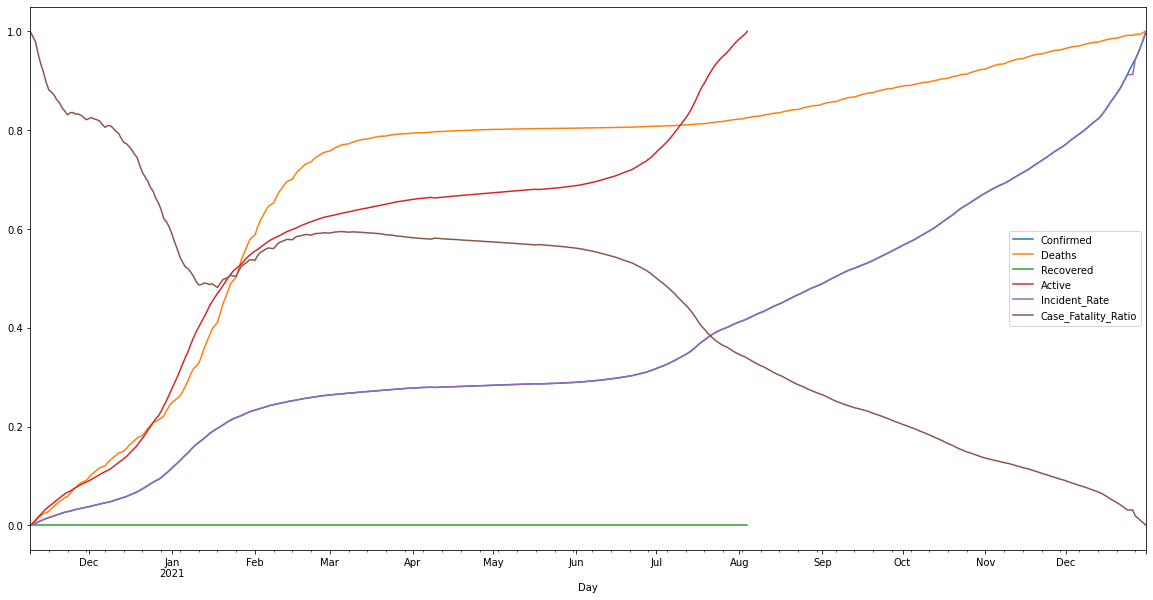

In [27]:
df_uk_england_3[selected_columns].plot(figsize=(20,10))
plt.savefig('output/uk_scoring_report.png')

In [30]:
df_uk_england_3.to_csv('output/India_scoring_report.csv')
df_uk_england_2.to_csv('output/India_scoring_report_NotScaled.csv')

In [33]:
host="ibrahim_hw2_postgres" # use "localhost" if you access from outside the localnet docker-compose env 
database="deproject"
user="postgres"
password="password123"
port='5432'
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
print(engine.table_names())


df_uk_england_3.to_sql('uk_scoring_report', engine,if_exists='replace',index=False)

['uk_scoring_report']


/tmp/ipykernel_1072/1291845025.py:7: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


418